## Final Project Submission

Please fill out:
* Student name: Devin Belden
* Student pace: full time
* Scheduled project review date/time: TBD
* Instructor name: James Irving, Ph.D
* Blog post URL: TBD

# Business Case

For this project, we attempt to answer four questions concerning the Northwind database, trying to find sources of statistically significant impacts on sales. By finding such impacts, we can focus our business efforts on a few key areas that will lead to growth, and potentially learn which facets of the business on which we should not focus, thereby applying a two-pronged approach to resource management.

To answer all of the following questions, we'll first need to import relevant packages, as well as initialize a SQLite cursor.

In [2]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

## Relationship 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

### Null Hypothesis ($H_0$): There is no statistically significant effect of any discount level on the quantity of a product in an order.
### Alternative Hypothesis ($H_1$): There is a statistically significant effect of discount level on quantity of a product in an order.

The phrasing of the question dictates a two-tailed test, as it leaves room for a discount level to *decrease* the quantity of product in an order. There may seem to be no logical reason to order less of a product if a discount is offered, but we'll make room for this circumstance nonetheless.

First, we'll execute a SQL query to pull relevant data.

In [3]:
cur.execute("""select discount, quantity, productid
               from orderdetail
               order by 1""")
df = pd.DataFrame(cur.fetchall(), columns=['discount','quantity','productid'])
df

,discount,quantity,productid
0,0.00,12,11
1,0.00,10,42
2,0.00,5,72
3,0.00,9,14
4,0.00,40,51
...,...,...,...
2150,0.25,4,30
2151,0.25,20,54
2152,0.25,20,6
2153,0.25,20,14


Let's take a look at the quantity of product sold at each discount level.

In [4]:
for i in list(df['discount'].unique()):
    print(i, len(df[df['discount'] == i]))

0.0 1317
0.01 1
0.02 2
0.03 3
0.04 1
0.05 185
0.06 1
0.1 173
0.15 157
0.2 161
0.25 154


Just by visual inspection, the sample sizes for 1-4%, as well as 6%, are rather small for meaningful statistical analysis. Nevertheless, we'll inspect every discount level just to be sure.

Next, we'll visually illustrate the existence of any impact on product quantity in an order based purely on whether a discount was given. Additionally, we'll test for normality in order to determine which test to use to compare the samples.

Text(0.5, 1.0, 'The Effect of Discounts on Order Quantity')

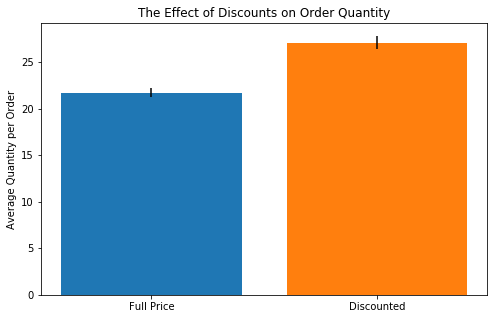

In [20]:
df['discounted'] = np.where(df['discount']==0.00,0,1)
df.head()
grp0 = df.groupby('discounted').get_group(0)['quantity']
grp1 = df.groupby('discounted').get_group(1)['quantity']

plt.figure(figsize=(8,5))
plt.bar(x='Full Price', height=grp0.mean(), yerr=stats.sem(grp0))

plt.bar(x='Discounted', height=grp1.mean(), yerr=stats.sem(grp1))
plt.ylabel("Average Quantity per Order")
plt.title("The Effect of Discounts on Order Quantity")

Looks like there might be some significant difference between order quantities based on whether or not a discount was offered. Let's check the distributions for normality and run the appropriate hypothesis test.

In [6]:
stats.normaltest(grp0), stats.normaltest(grp1)

(NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119),
 NormaltestResult(statistic=261.5280122997891, pvalue=1.6214878452828687e-57))

Since the distributions are not normal, we should use a non-parametric test such as Mann-Whitney.

In [7]:
stats.mannwhitneyu(grp0, grp1, alternative='two-sided')

MannwhitneyuResult(statistic=461541.0, pvalue=1.3258763653999732e-10)

Interesting to note that running a two-tailed test as opposed to a single tailed made no difference in the end.

A P-value this low means we've achieved at least some statistical significance. Let's run a Tukey test to see which discount level matters most.

In [8]:
import statsmodels.api as sms
data = df['quantity'].values
labels = df['discount'].values
model = sms.stats.multicomp.pairwise_tukeyhsd(data, labels)
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


Text(0.5, 1.0, 'Comparison of Discount Levels')

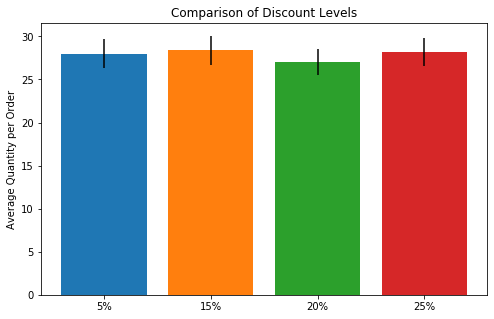

In [18]:
grp5 = df.groupby('discount').get_group(0.05)['quantity']
grp15 = df.groupby('discount').get_group(0.15)['quantity']
grp20 = df.groupby('discount').get_group(0.2)['quantity']
grp25 = df.groupby('discount').get_group(0.25)['quantity']

plt.figure(figsize=(8,5))
plt.bar(x='5%', height=grp5.mean(), yerr=stats.sem(grp5))
plt.bar(x='15%', height=grp15.mean(), yerr=stats.sem(grp15))
plt.bar(x='20%', height=grp20.mean(), yerr=stats.sem(grp20))
plt.bar(x='25%', height=grp25.mean(), yerr=stats.sem(grp25))

plt.ylabel("Average Quantity per Order")
plt.title("Comparison of Discount Levels")

Looks like discount levels of 5%, 15%, 20%, and 25% all lead to statistically significant increases in amount of product sold in a given order. However, none of these discount levels, when compared to each other, lead to statistically significant increases, as shown in the above graph. In essence, we cannot say that a customer will order more product when given a 25% discount than when given a mere 5% off. We can see this visually as well:

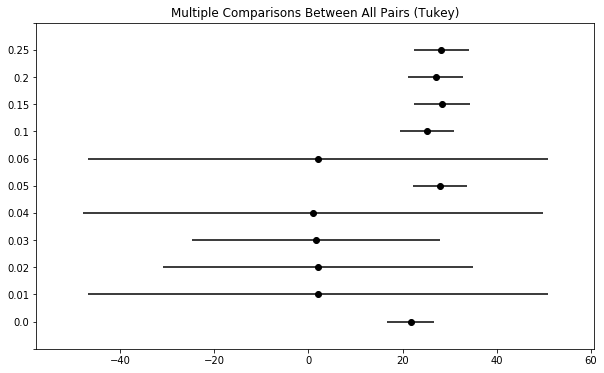

In [21]:
model.plot_simultaneous();

As seen above, the confidence intervals for our selected discount levels eclipse each others' means but not the 0% discount level, whereas the confidence interval for, say, a 10% discount level eclipses the mean of the 0% level. Thus, we can reject the null hypothesis and say that the selected discount levels provide a statistically significant increase in product quantity per order.

### Conclusion: Discount levels of 5%, 15%, 20%, and 25% all result in statistically significant (p < 0.05) increases in quantity of product per order.

## Relationship 2: Does the quantity of product sold fluctuate with the time of year? If so, when are more products being sold?

### $H_0$: There is no statistically significant effect of time of year on total quantity of product sold.
### $H_1$: Time of year has a statistically significant impact on total quantity of product sold.

For this test, we'll split the time of year into quarters. As usual, let's start by pulling the relevant data in an SQL query.

In [22]:
cur.execute("""select o.shipcountry, o.orderdate, sum(od.quantity) from 'order' o
               join orderdetail od
               on o.id = od.orderid
               group by 2""")
df = pd.DataFrame(cur.fetchall(), columns=['shipcountry','orderdate','quantity'])
df

,shipcountry,orderdate,quantity
0,France,2012-07-04,27
1,Germany,2012-07-05,49
2,Brazil,2012-07-08,101
3,Belgium,2012-07-09,105
4,Brazil,2012-07-10,102
...,...,...,...
475,Italy,2014-04-30,151
476,USA,2014-05-01,277
477,Germany,2014-05-04,101
478,Germany,2014-05-05,365


We'll need to massage this data into an appropriate format, including adding a column for the quarter of the year. 

In [23]:
df['orderdate'] = pd.to_datetime(df['orderdate'], format='%Y/%m/%d')
df['quarter'] = df['orderdate'].dt.to_period("q")
df['quarter'] = df.apply(lambda row: int(str(row['quarter'])[-1]), axis=1)
df.head()

,shipcountry,orderdate,quantity,quarter
0,France,2012-07-04,27,3
1,Germany,2012-07-05,49,3
2,Brazil,2012-07-08,101,3
3,Belgium,2012-07-09,105,3
4,Brazil,2012-07-10,102,3


Text(0, 0.5, 'Average Quantity per Order')

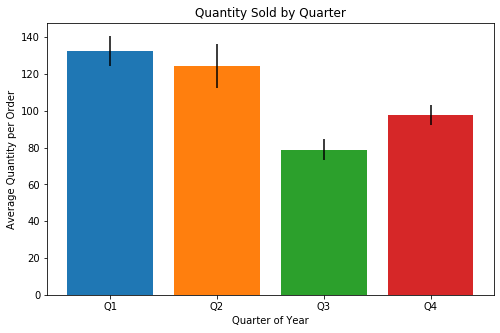

In [24]:
grp0 = df.groupby('quarter').get_group(1)['quantity']
grp1 = df.groupby('quarter').get_group(2)['quantity']
grp2 = df.groupby('quarter').get_group(3)['quantity']
grp3 = df.groupby('quarter').get_group(4)['quantity']

plt.figure(figsize=(8,5))
plt.bar(x='Q1', height=grp0.mean(), yerr=stats.sem(grp0))
plt.bar(x='Q2', height=grp1.mean(), yerr=stats.sem(grp1))
plt.bar(x='Q3', height=grp2.mean(), yerr=stats.sem(grp2))
plt.bar(x='Q4', height=grp3.mean(), yerr=stats.sem(grp3))
plt.title("Quantity Sold by Quarter")
plt.xlabel("Quarter of Year")
plt.ylabel("Average Quantity per Order")

Just for fun, we'll test for normality of the distributions.

In [25]:
for grp in [grp0,grp1,grp2,grp3]:
    print(stats.normaltest(grp))

NormaltestResult(statistic=71.88070533047213, pvalue=2.462085666549949e-16)
NormaltestResult(statistic=63.04152441886395, pvalue=2.0450640156162815e-14)
NormaltestResult(statistic=48.25959334243682, pvalue=3.31560248332186e-11)
NormaltestResult(statistic=13.21563374774304, pvalue=0.0013497756657326514)


As expected, these distributions are not normally distributed, but since our sample sizes are over 15, we can still use ANOVA.

In [26]:
from scipy.stats import f_oneway

f_oneway(grp0,grp1,grp2,grp3)

F_onewayResult(statistic=10.936050410502693, pvalue=5.879748582008128e-07)

Looks like we've got a low enough P-value to confidently reject the null hypothesis. Once again, we can run Tukey test to see which quarters see a statistically significant change in total quantity of product sold.

In [27]:
data = df['quantity'].values
labels = df['quarter'].values
model = sms.stats.multicomp.pairwise_tukeyhsd(data, labels)
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-8.1064,0.8837,-37.3175,21.1048,False
1,3,-53.6079,0.001,-80.1857,-27.03,True
1,4,-34.7625,0.0042,-61.1895,-8.3356,True
2,3,-45.5015,0.001,-74.6656,-16.3374,True
2,4,-26.6562,0.0849,-55.6829,2.3705,False
3,4,18.8453,0.255,-7.5296,45.2202,False


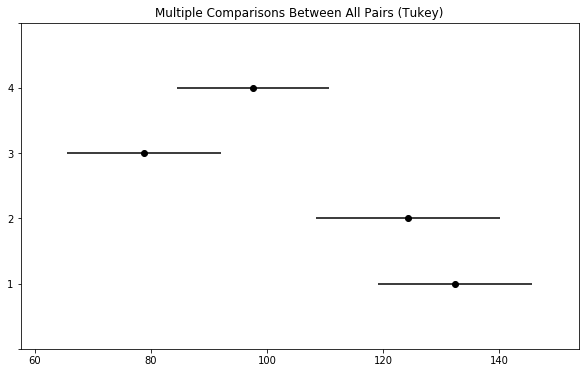

In [28]:
model.plot_simultaneous();

Looks like we can confidently reject the null hypothesis and say that there is a statistically significant difference in total sales depending on the time of year.

### Conclusion: There is a statistically significant (p < 0.05) difference in total sales depending on the time of year.

### Relationship 3: Is there a statistically significant difference in sales between employees throughout the company, depending on their age? If so, which employees are selling more?

#### $H_0$: There is no statistically significant effect of an employee's age on their selling ability.

#### $H_1$: There is a statistically significant effect of an employee's age on their selling ability.

Once again, we'll pull relevant data using SQL.

In [29]:
cur.execute("""select distinct o.id, e.birthdate, od.unitprice, od.quantity
               from 'order' o
               join employee e on o.employeeid = e.id
               join orderdetail od on o.id = od.orderid
               order by 2""")
revenue_by_birthdate = pd.DataFrame(cur.fetchall(), columns=['Order ID','Birthdate','Unit Price','Quantity'])

revenue_by_birthdate['Total Revenue by item'] = revenue_by_birthdate.apply(lambda row: 
                                                                         row['Unit Price']*row['Quantity'], axis=1)
revenue_by_birthdate

,Order ID,Birthdate,Unit Price,Quantity,Total Revenue by item
0,10250,1969-09-19,7.7,10,77.0
1,10250,1969-09-19,42.4,35,1484.0
2,10250,1969-09-19,16.8,15,252.0
3,10252,1969-09-19,64.8,40,2592.0
4,10252,1969-09-19,2.0,25,50.0
...,...,...,...,...,...
2149,11022,1998-01-27,9.2,35,322.0
2150,11022,1998-01-27,36.0,30,1080.0
2151,11058,1998-01-27,10.0,3,30.0
2152,11058,1998-01-27,34.0,21,714.0


We could have just as easily grouped this by employee ID or any other column descriptive of the employees themselves, but grouping by birthdate (and therefore age) adds another dimension to the statistical inference.

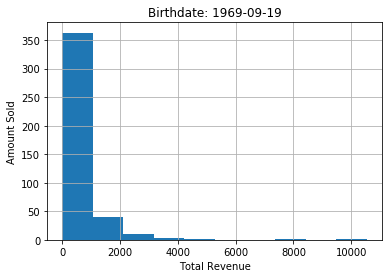

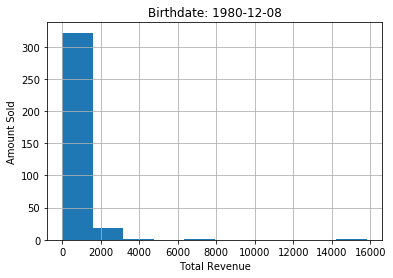

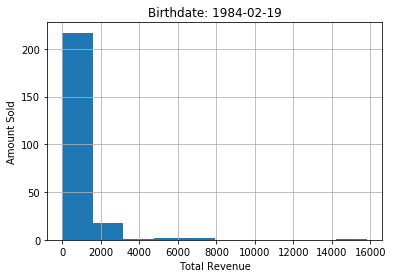

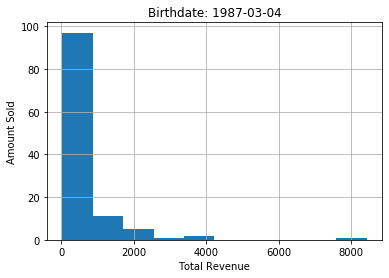

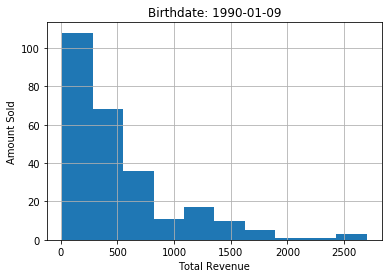

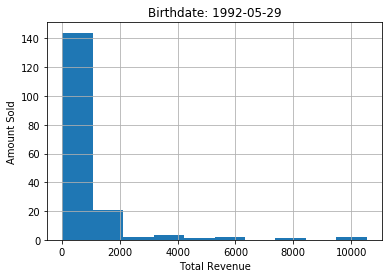

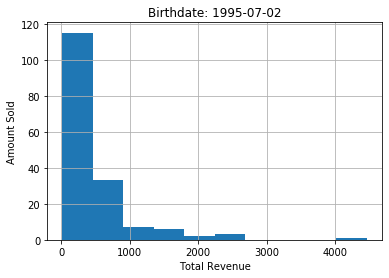

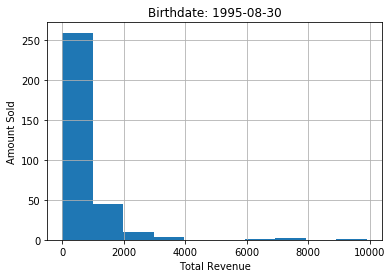

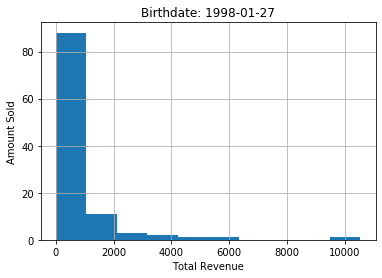

In [30]:
for date in revenue_by_birthdate['Birthdate'].unique():
    revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == date].hist(column='Total Revenue by item')
    plt.title("Birthdate: "+ str(date))
    plt.xlabel('Total Revenue')
    plt.ylabel('Amount Sold')

Below is a graph comparing the average sales 

Text(0, 0.5, 'Average Revenue Sold')

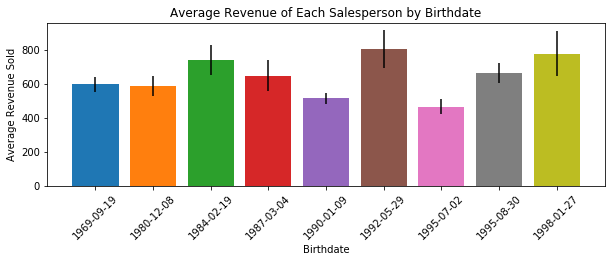

In [60]:
grp0 = revenue_by_birthdate.groupby('Birthdate').get_group('1969-09-19')['Total Revenue by item']
grp1 = revenue_by_birthdate.groupby('Birthdate').get_group('1980-12-08')['Total Revenue by item']
grp2 = revenue_by_birthdate.groupby('Birthdate').get_group('1984-02-19')['Total Revenue by item']
grp3 = revenue_by_birthdate.groupby('Birthdate').get_group('1987-03-04')['Total Revenue by item']
grp4 = revenue_by_birthdate.groupby('Birthdate').get_group('1990-01-09')['Total Revenue by item']
grp5 = revenue_by_birthdate.groupby('Birthdate').get_group('1992-05-29')['Total Revenue by item']
grp6 = revenue_by_birthdate.groupby('Birthdate').get_group('1995-07-02')['Total Revenue by item']
grp7 = revenue_by_birthdate.groupby('Birthdate').get_group('1995-08-30')['Total Revenue by item']
grp8 = revenue_by_birthdate.groupby('Birthdate').get_group('1998-01-27')['Total Revenue by item']

plt.figure(figsize=(10,3))
plt.bar(x='1969-09-19', height=grp0.mean(), yerr=stats.sem(grp0))
plt.bar(x='1980-12-08', height=grp1.mean(), yerr=stats.sem(grp1))
plt.bar(x='1984-02-19', height=grp2.mean(), yerr=stats.sem(grp2))
plt.bar(x='1987-03-04', height=grp3.mean(), yerr=stats.sem(grp3))
plt.bar(x='1990-01-09', height=grp4.mean(), yerr=stats.sem(grp4))
plt.bar(x='1992-05-29', height=grp5.mean(), yerr=stats.sem(grp5))
plt.bar(x='1995-07-02', height=grp6.mean(), yerr=stats.sem(grp6))
plt.bar(x='1995-08-30', height=grp7.mean(), yerr=stats.sem(grp7))
plt.bar(x='1998-01-27', height=grp8.mean(), yerr=stats.sem(grp8))

plt.title("Average Revenue of Each Salesperson by Birthdate")
plt.xlabel("Birthdate")
plt.xticks(rotation='45')
plt.ylabel("Average Revenue Sold")

Next, we'll break up the data into individual dataframes of each employee's total revenue sold. Then we'll run the non-parametric Kruskal-Wallis H-test to check for similarity between datasets.

(Note: if the code in the following cell looks abysmal, that's because it is.)

In [31]:
a = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1969-09-19']
a = a['Total Revenue by item']
b = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1980-12-08']
b = b['Total Revenue by item']
c = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1984-02-19']
c = c['Total Revenue by item']
d = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1987-03-04']
d = d['Total Revenue by item']
e = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1990-01-09']
e = e['Total Revenue by item']
f = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1992-05-29']
f = f['Total Revenue by item']
g = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1995-07-02']
g = g['Total Revenue by item']
h = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1995-08-30']
h = h['Total Revenue by item']
i = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1998-01-27']
i = i['Total Revenue by item']

In [32]:
from scipy.stats import kruskal

kruskal(a,b,c,d,e,f,g,h,i)

KruskalResult(statistic=10.766600688693485, pvalue=0.2152778357561379)

A rather high P-value, which tells us we cannot confidently reject the null hypothesis.

### Conclusion: An employee's birthdate has no statistically significant (p > 0.05) effect on their total revenue sold.

### Relationship 4: Is there a statistically significant difference in average discount level per order between both US and UK locations? If so, which office is giving more discounts?

Since we know that discount level has a statistically significant effect on the quantity in an order, why don't we find out where most of the discounts are coming from?

#### $H_0$: There is no statistically significant difference in average discount amount per order between the US and UK offices.

#### $H_1$: There is a statistically significant difference in average discount amount per order between the US and UK offices.

Since we have no idea which office offers more discounts, it makes sense to make this a two-tailed test, as will become relevant later.

In [33]:
cur.execute("""select distinct o.id, e.country, avg(od.discount)
               from 'order' o
               join employee e on e.id = o.employeeid
               join orderdetail od on od.orderid = o.id
               group by 1""")
discount_by_country = pd.DataFrame(cur.fetchall(), columns=['orderID','country of sales rep','average discount in order'])
discount_by_country

,orderID,country of sales rep,average discount in order
0,10248,UK,0.000000
1,10249,UK,0.000000
2,10250,USA,0.100000
3,10251,USA,0.033333
4,10252,USA,0.033333
...,...,...,...
825,11073,USA,0.000000
826,11074,UK,0.050000
827,11075,USA,0.150000
828,11076,USA,0.250000


In [34]:
grp0 = discount_by_country.groupby('country of sales rep').get_group('UK')['average discount in order']
grp1 = discount_by_country.groupby('country of sales rep').get_group('USA')['average discount in order']

Text(0.5, 1.0, 'Average Discount Level by Country')

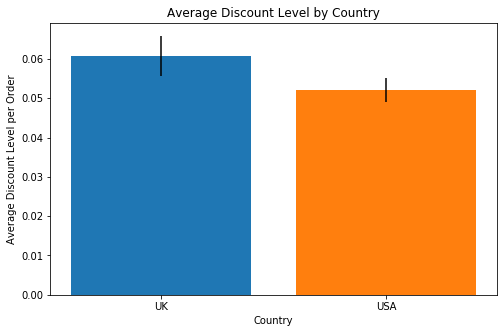

In [35]:
plt.figure(figsize=(8,5))
plt.bar(x='UK', height=grp0.mean(), yerr=stats.sem(grp0))
plt.bar(x='USA', height=grp1.mean(), yerr=stats.sem(grp1))
plt.xlabel("Country")
plt.ylabel("Average Discount Level per Order")
plt.title("Average Discount Level by Country")

It looks like there could be a statistically significant difference between the two. Let's probe further, using normality test and parametric vs. non-parametric tests to check our hypothesis.

In [36]:
stats.normaltest(grp0), stats.normaltest(grp1)

(NormaltestResult(statistic=29.21057587088821, pvalue=4.5394584260173466e-07),
 NormaltestResult(statistic=114.84021802148685, pvalue=1.155482856407473e-25))

In [37]:
# what happens if we run anova?
f_oneway(grp0, grp1)

F_onewayResult(statistic=2.2234335387227073, pvalue=0.13631131652445494)

In [38]:
#ruh roh. what happens if we run mann whitney?
stats.mannwhitneyu(grp0,grp1, alternative='two-sided')

MannwhitneyuResult(statistic=72740.0, pvalue=0.08325052765573286)

A P-value slightly too high to reject the null hypothesis. We cannot confidently say that the UK gives out more or fewer discounts than the US office. It's worth noting, especially considering the Mann-Whitney test's P-value, that specifying a two-tailed test caused us to fail to reject the null hypothesis, whereas specifying a single-tailed test would result in a P-value of 0.04, grounds for rejecting the null hypothesis.

### Conclusion: There is no statistically significant (p > 0.05) difference in average discount level given between the UK and US offices.

# Summary of Conclusions

* Discount levels of 5%, 15%, 20%, and 25% all result in higher order volumes.
* A discount of 5% is just as effective at moving product as a 25% discount.
* Q1 and Q2 sales volume is higher than Q3 and Q4. 

Given the above three points, there is motivation to increase sales efforts during Q3 and Q4, and a technique to increase these sales is to offer products at 5% discount.